In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
import neurokit2 as nk
from scipy.optimize import least_squares
from scipy.signal import spectrogram

In [3]:
def readCsv(pathFile):
    arrays = []

    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        for line in lines:
            line_values = line.strip().split(',')
            arrays.append(line_values)
    complex_array = []
    for array in arrays:

        complex_value = np.array(
            [complex(element.replace('i', 'j')) for element in array])
        complex_array.append(complex_value)
    np.array(complex_array)
    return np.array(complex_array)

In [4]:
#read data
file_path = '../FMCW Radar/Rawdata/Rawdata_1.csv'
raw_data = readCsv(file_path)
raw_data_channel_0 = raw_data[0]

In [5]:
T_c = 91.72 * (1e-6)   # Chirp time
NUM_SAMPLE_CHIRP = 256
B =3.75 * (1e9) #bandwidth
# Calculate frequency variation
wavelength=3.947
speed_of_light = 300000000


In [6]:
chirps = [raw_data_channel_0[i:i+NUM_SAMPLE_CHIRP] for i in range(0, len(raw_data_channel_0), NUM_SAMPLE_CHIRP)]
print("shape of chirp {0}".format(np.array(chirps).shape))

shape of chirp (12000, 256)


In [7]:
range_resolution=float(speed_of_light)/(2*B)
print("Range resolution {0} mm".format(range_resolution*1e3))


Range resolution 40.0 mm


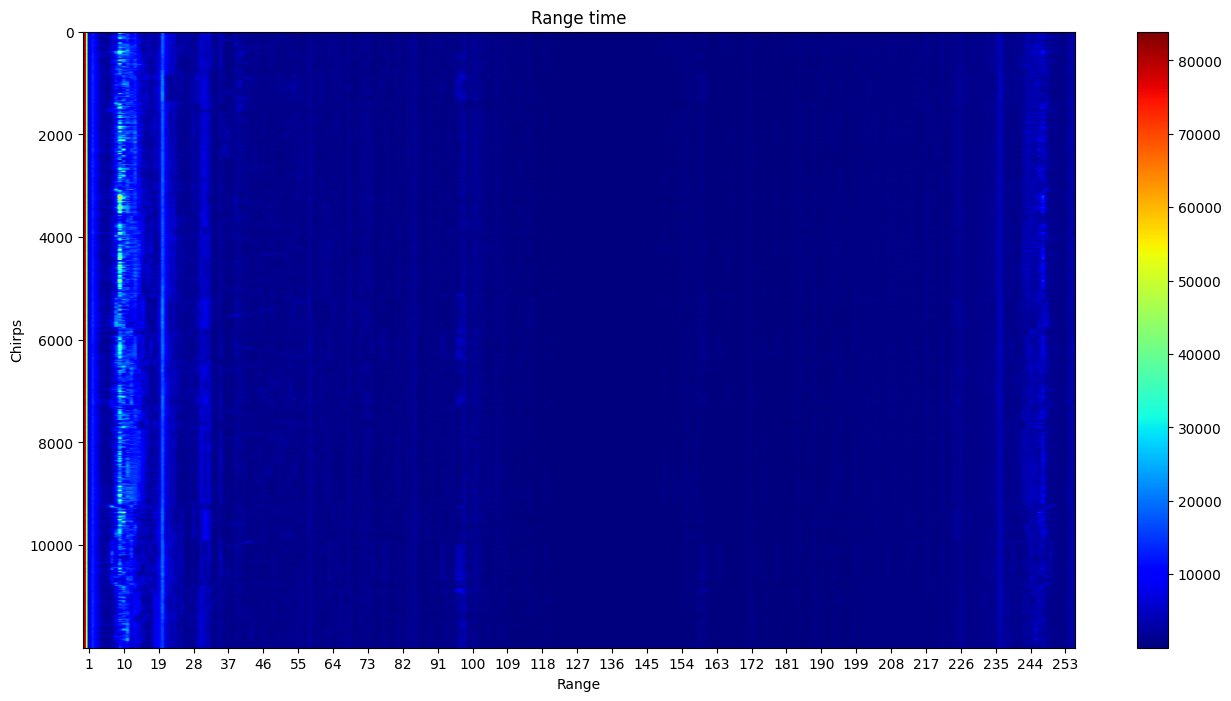

In [8]:
#Make range FFT over chirps
NFFT=256
range_time_matrix = np.fft.fft(chirps,NFFT,axis=1)
range_time_abs_matrix=np.abs(range_time_matrix)
rangeBinDistance =[j for j in range(1,NFFT,9) ]

plt.figure(figsize=(16,8))
plt.xlabel('Range')
plt.ylabel('Chirps')
plt.imshow(range_time_abs_matrix,aspect='auto',cmap='jet')
plt.xticks(range(1,NFFT,9), rangeBinDistance)
plt.colorbar()
plt.title("Range time")
plt.show()


In [9]:
def residuals(params, x1, x2):
    a, b, c = params
    return (x1 - a)**2 + (x2 - b)**2 - c

initial_params=np.array([0.3,0.1,0.8])
one_chirp_result = least_squares(residuals, initial_params, args=(np.real(range_time_matrix).flatten(), (np.imag(range_time_matrix).flatten())))
a,b,c =one_chirp_result.x
DC_compensation =a+b*1j 
chirps_with_DC_removal = np.array([ (target_data_sample -DC_compensation) for target_data_sample  in np.array(range_time_matrix).flatten()])

In [10]:
new_range_time_matrix  =chirps_with_DC_removal.reshape(np.array(chirps).shape)

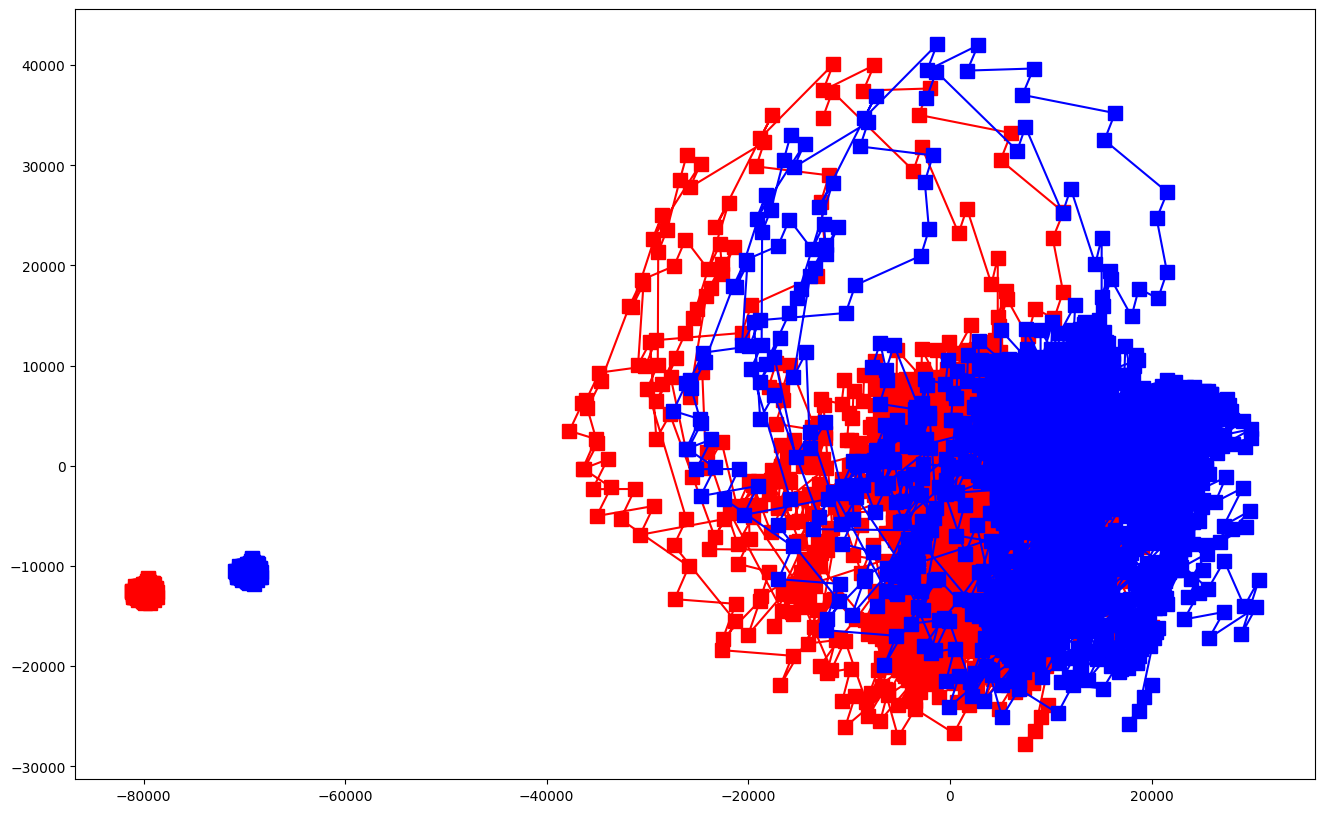

In [11]:
target_data_sample_real =np.real(range_time_matrix[:300]) 
target_data_sample_image =np.imag(range_time_matrix[:300]) 

target_data_sample_real_with_DC =np.real(new_range_time_matrix[:300]) 
target_data_sample_image_with_DC =np.imag(new_range_time_matrix[:300]) 


plt.figure(figsize=(16, 10))
plt.plot(target_data_sample_real, target_data_sample_image, 'rs-', markeredgewidth=1, markersize=10,linewidth=0)
plt.plot(target_data_sample_real, target_data_sample_image, color='red')

plt.plot(target_data_sample_real_with_DC, target_data_sample_image_with_DC, 'bs-', markeredgewidth=1, markersize=10,linewidth=0)
plt.plot(target_data_sample_real_with_DC, target_data_sample_image_with_DC, color='blue')
plt.show()

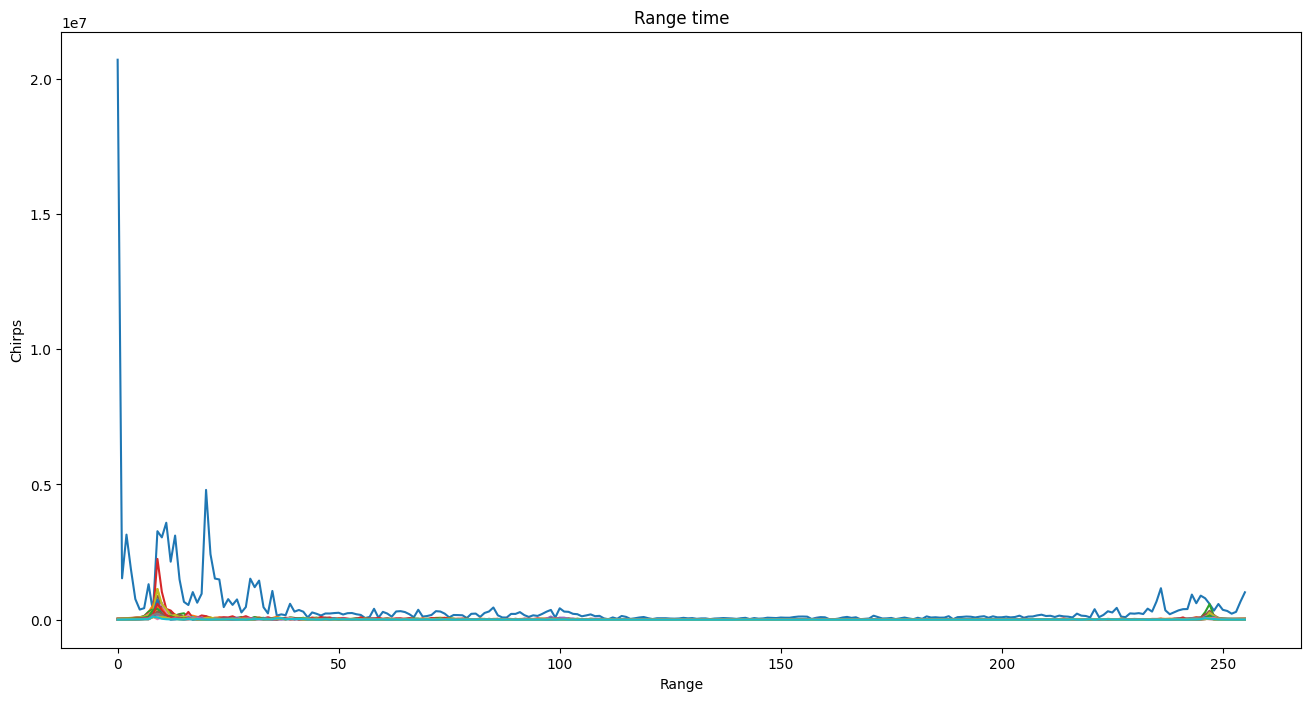

In [12]:
NFFT=256
vibration_matrix = np.fft.fft(range_time_matrix,NFFT,axis=0)
vibration_abs_matrix=np.abs(vibration_matrix)


plt.figure(figsize=(16,8))
plt.xlabel('Range')
plt.ylabel('Chirps')
#plt.imshow(vibration_abs_matrix,aspect='auto',cmap='jet')
for i in range(0,20):
    plt.plot(vibration_abs_matrix[i])

plt.title("Range time")
plt.show()


In [13]:
indices_of_range =[0]*np.array(vibration_abs_matrix).shape[1]
for range_time in vibration_abs_matrix:
    max_index = np.argmax(range_time[1:])
    indices_of_range[max_index]+=1
interesting_bin =np.argmax(indices_of_range)

print("Target at bin :{0}th, distance: {1}m".format(interesting_bin,interesting_bin* range_resolution))
# for i,e in enumerate(indices_of_range):
#     if(e!=0):
#         print("{0}th{1}".format(i,e))

Target at bin :8th, distance: 0.32m


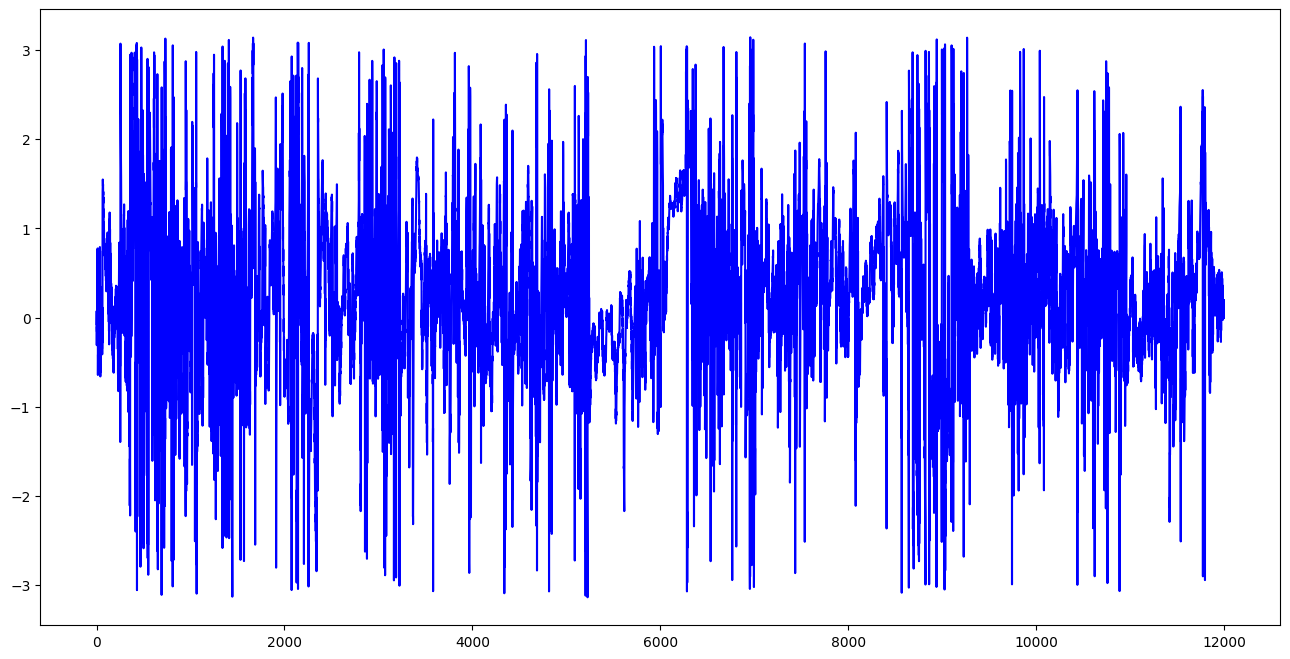

In [14]:
interest_bin_phase = np.array(new_range_time_matrix)[:,interesting_bin]
phase_angle =np.angle(interest_bin_phase)
# phase_angle_unwrapped = np.diff(np.unwrap(phase_angle))
phase_angle_unwrapped =phase_angle
plt.figure(figsize=(16,8))
plt.plot(phase_angle_unwrapped,color="blue")
plt.show()

In [15]:
def filter_signal (signal_to_filter ,_low_freq,_high_freq,_sampling_rate,_filter_order):
    sampling_rate = _sampling_rate# Sampling rate of the input signal
    low_freq = _low_freq  # Lower cutoff frequency of the bandpass filter
    high_freq = _high_freq  # Upper cutoff frequency of the bandpass filter
    filter_order = _filter_order # Order of the bandpass filter

    # Compute the normalized cutoff frequencies
    nyquist_freq = 0.5 * sampling_rate
    low_norm = low_freq / nyquist_freq
    high_norm = high_freq / nyquist_freq
    
    # Design the bandpass filter
    b, a = butter(filter_order, [low_norm, high_norm], btype='band')

    # Apply the bandpass filter to the input signal
    signal_filtered = filtfilt(b, a, signal_to_filter)
    return signal_filtered

In [16]:
EXTRACTED_SAMPLING_RATE=40
breath_heart_band_filtering=[float(45)/60,float(125)/60]
filtered_signal =filter_signal(np.array(phase_angle_unwrapped),breath_heart_band_filtering[0],breath_heart_band_filtering[1],EXTRACTED_SAMPLING_RATE,4)

breath_band_filtering=[float(20)/60,float(60)/60]
breath_filtered_signal =filter_signal(np.array(phase_angle_unwrapped),breath_band_filtering[0],breath_band_filtering[1],EXTRACTED_SAMPLING_RATE,4)

heart_band_filtering=[float(80)/60,float(120)/60]
heart_filtered_signal =filter_signal(np.array(phase_angle_unwrapped),heart_band_filtering[0],heart_band_filtering[1],EXTRACTED_SAMPLING_RATE,4)

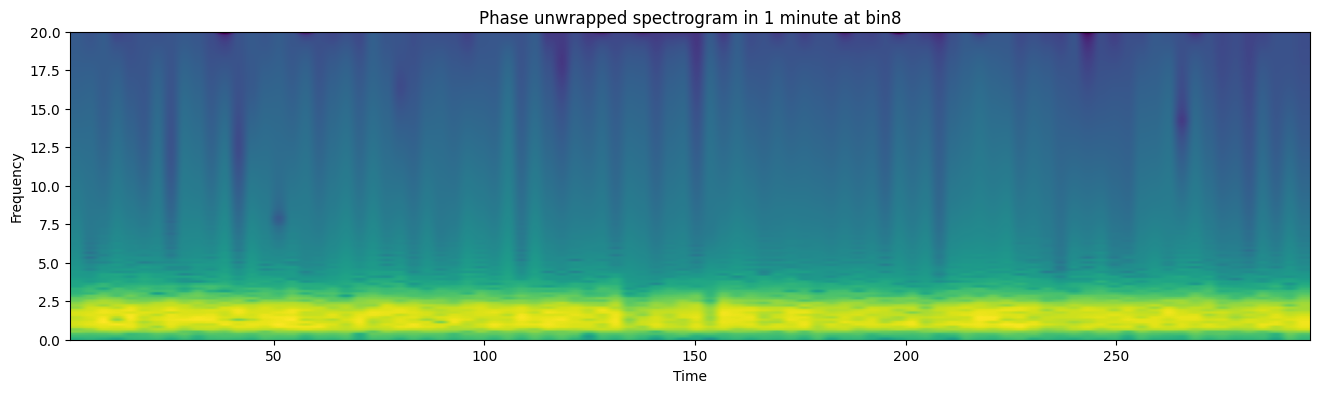

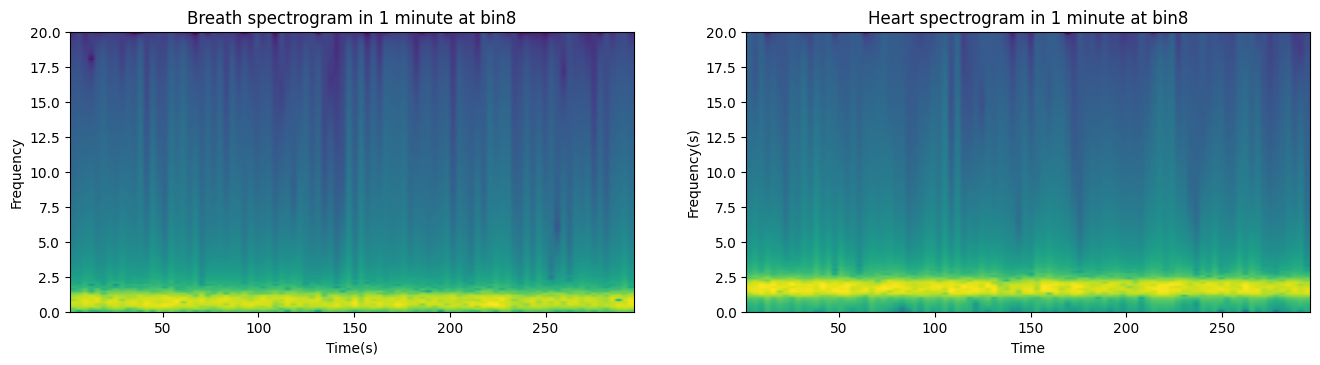

In [17]:
plt.figure(figsize=(16,4))
plt.specgram(filtered_signal,Fs=EXTRACTED_SAMPLING_RATE)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.title("Phase unwrapped spectrogram in 1 minute at bin{0}".format(interesting_bin))
plt.show()

plt.figure(figsize=(16,8))
plt.subplot(221)
plt.specgram(breath_filtered_signal,Fs=EXTRACTED_SAMPLING_RATE)
plt.xlabel("Time(s)")
plt.ylabel("Frequency")
plt.title("Breath spectrogram in 1 minute at bin{0}".format(interesting_bin))

plt.subplot(222)
plt.specgram(heart_filtered_signal,Fs=EXTRACTED_SAMPLING_RATE)
plt.xlabel("Time")
plt.ylabel("Frequency(s)")
plt.title("Heart spectrogram in 1 minute at bin{0}".format(interesting_bin))

plt.show()

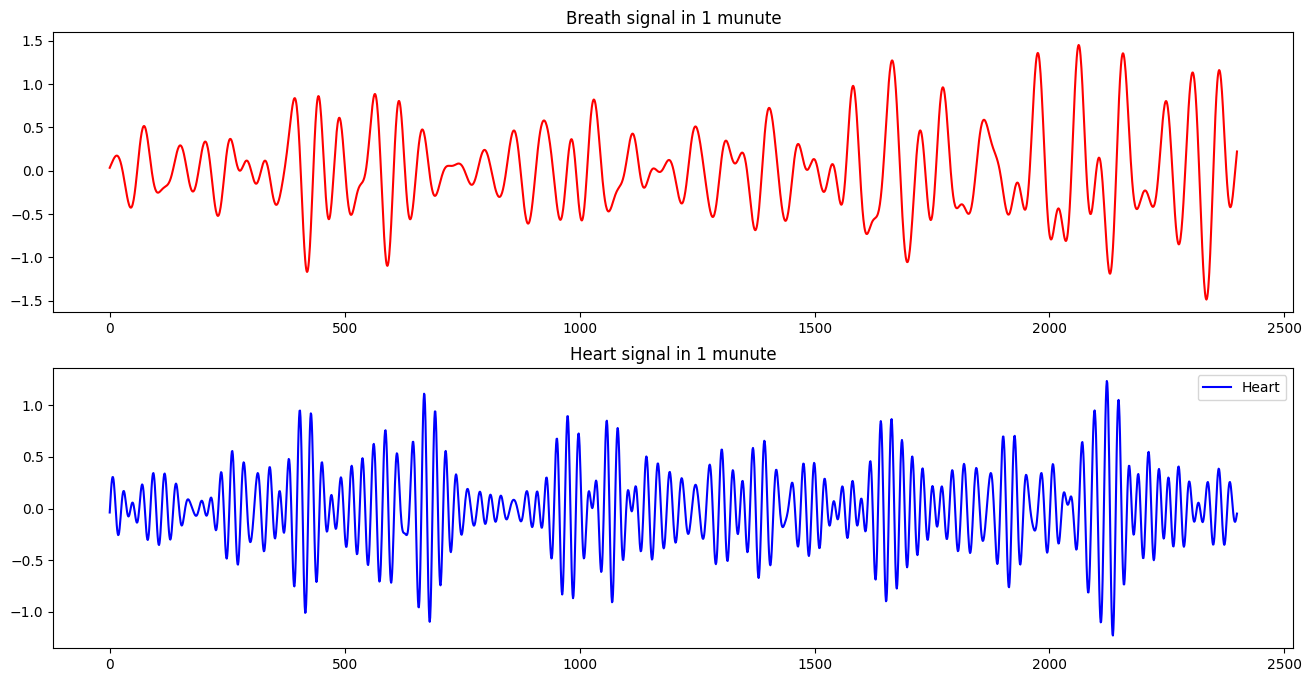

In [18]:
plt.figure(figsize=(16,8))
plt.subplot(211)
plt.plot(breath_filtered_signal[:2400],color="red",label="Breath")
plt.title("Breath signal in 1 munute")
plt.subplot(212)
plt.plot(heart_filtered_signal[:2400],color="blue",label="Heart")
plt.title("Heart signal in 1 munute")
plt.legend()

plt.show()